In [44]:

import numpy as np
import pandas as pd
import _pickle as pickle
#from collections import defaultdict
#import re
#import ast

# from bs4 import BeautifulSoup

import sys
import os
import json
import operator

#from keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical

#from keras import backend as K
#from keras.engine.topology import Layer, InputSpec
#from keras import initializers

#from keras.optimizers import SGD

#from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, GlobalAveragePooling1D, LSTM, GRU, Bidirectional, dot, multiply, Lambda, TimeDistributed, Masking

#from keras.models import Model, Sequential
#from keras.regularizers import l2,l1,l1_l2
#from keras.callbacks import Callback,EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

#from keras.callbacks import Callback


#from keras.layers.normalization import BatchNormalization
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# from collections import OrderedDict
# from lime.lime_text import LimeTextExplainer 
# from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import text

In [7]:
from sklearn.metrics import average_precision_score

In [8]:
import pickle

In [9]:
import optunity.metrics

In [10]:
from scipy import sparse

In [11]:
def load_data(data_name):
    f = open(data_name,'rb')
    data = pickle.load(f)
    return data

In [12]:
train_labels = load_data('/home/jujun/fraudprediction_10k/data/y_train_20200214')

In [13]:
len(train_labels)

45030

In [14]:
test_labels = load_data('/home/jujun/fraudprediction_10k/data/y_test_20200214')

In [15]:
len(test_labels)

11258

In [16]:
train_indecis = load_data('/home/jujun/fraudprediction_10k/data/indices_train_20200214')

In [17]:
test_indecis = load_data('/home/jujun/fraudprediction_10k/data/indices_test_20200214')

In [19]:
#data = load_data('/home/jujun/fraudprediction_10k/data/data_20200212_2012')

In [20]:
text_para = []
#labels = []
for d in data:
    text_para.append(d[0])
    #labels.append(d[1])

In [14]:
# with open('label_20200214_2012', 'wb') as fp:
#      pickle.dump(labels, fp)
# fp.close()

In [15]:
def generate_doc(x):
    return ' '.join(x)

In [16]:
text_doc = []
for d in text_para:
    text_doc.append(generate_doc(d))

In [17]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["dd"])

In [18]:
tfidf_vect = TfidfVectorizer(stop_words = my_stop_words, min_df=5)
tm= tfidf_vect.fit_transform(text_doc)

In [19]:
type(tm)

scipy.sparse.csr.csr_matrix

In [20]:
tm

<56288x69185 sparse matrix of type '<class 'numpy.float64'>'
	with 48325957 stored elements in Compressed Sparse Row format>

In [21]:
#sparse.save_npz('/home/jujun/fraudprediction_10k/data/tm_20200212', tm)

In [21]:
tm = sparse.load_npz("/home/jujun/fraudprediction_10k/data/tm_20200212.npz")

In [22]:
X_train = tm[train_indecis]
X_test = tm[test_indecis]

In [23]:
X_train.shape

(45030, 69185)

In [24]:
X_test.shape

(11258, 69185)

In [25]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(train_labels),
                                             train_labels)
class_weights_dict[0] = class_weights[0]
class_weights_dict[1] = class_weights[1]
print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

{0: 0.5045378151260504, 1: 55.592592592592595}


In [26]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.922474,0.368153,0.993526,0.474453,0.996752,0.375723,0.99032,0.643564,11157,101


In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [28]:
X_test.shape

(11258, 69185)

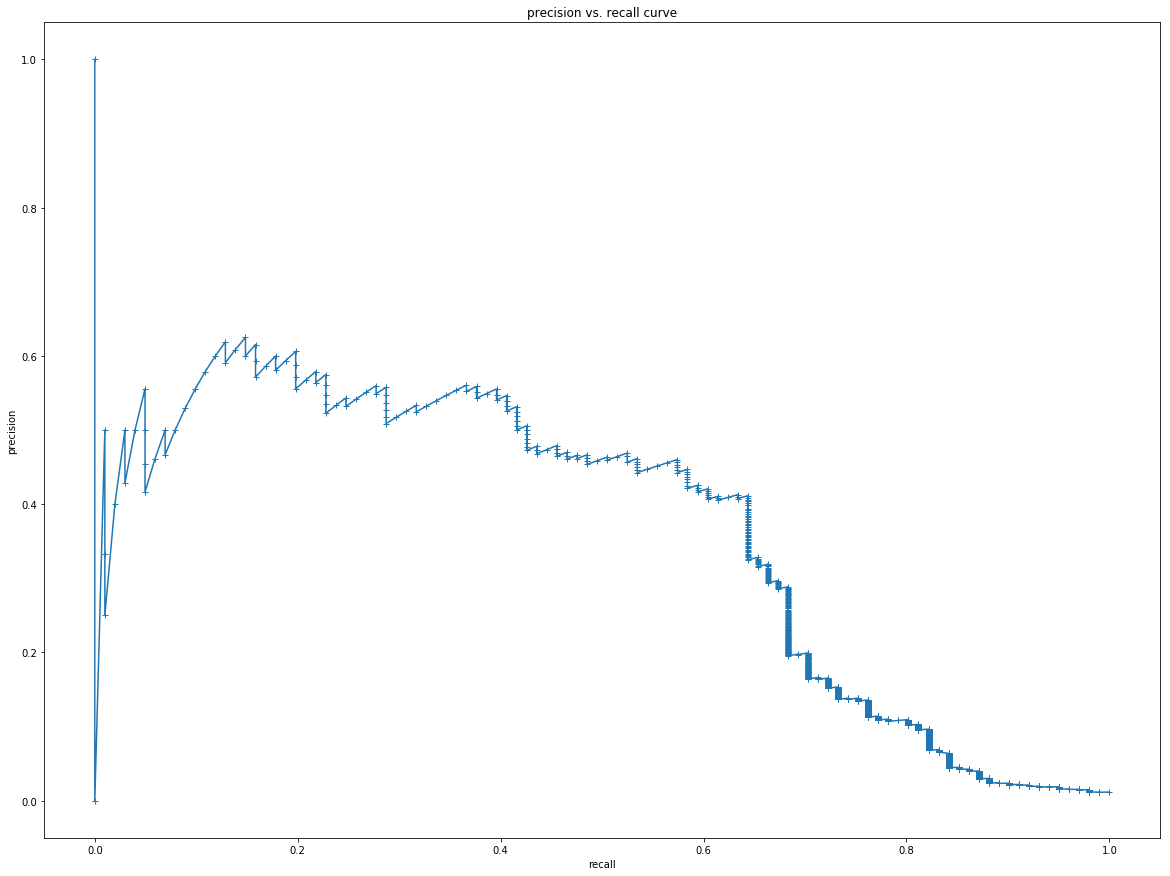

In [39]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(20,15))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()

In [42]:
rc

array([1.        , 0.99009901, 0.99009901, ..., 0.00990099, 0.        ,
       0.        ])

In [43]:
prc

array([0.01163326, 0.01151941, 0.01152074, ..., 0.5       , 0.        ,
       1.        ])

In [45]:
ap_1 = auc(rc, prc)

In [46]:
ap_1

0.36050147948102934

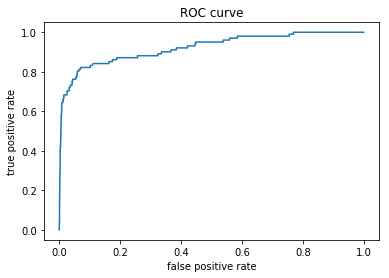

In [37]:
fpr, tpr, _ = roc_curve(test_labels, decision_values)

plt.plot(fpr, tpr)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.show()

In [49]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 75
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [50]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.92473,0.389777,0.994114,0.498084,0.996756,0.40625,0.991485,0.643564,11157,101


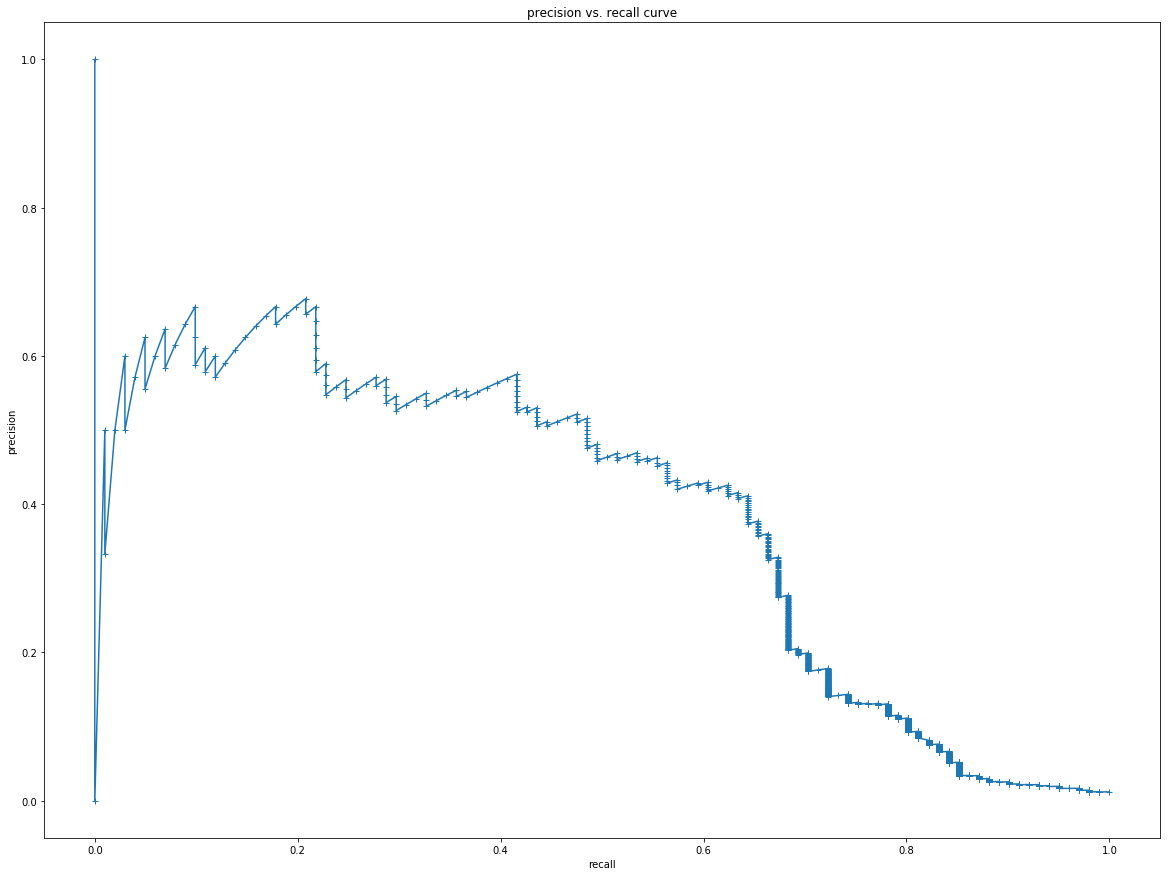

In [51]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(20,15))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()

In [52]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 50
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [53]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.925169,0.427077,0.99443,0.511811,0.996758,0.424837,0.992113,0.643564,11157,101


In [54]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 25
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [55]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.925004,0.467583,0.995243,0.547009,0.996674,0.481203,0.993816,0.633663,11157,101


In [56]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 10
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [57]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.924522,0.491416,0.996146,0.574257,0.996146,0.574257,0.996146,0.574257,11157,101


In [58]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 5
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [59]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.924366,0.490773,0.996285,0.531073,0.995171,0.618421,0.997401,0.465347,11157,101


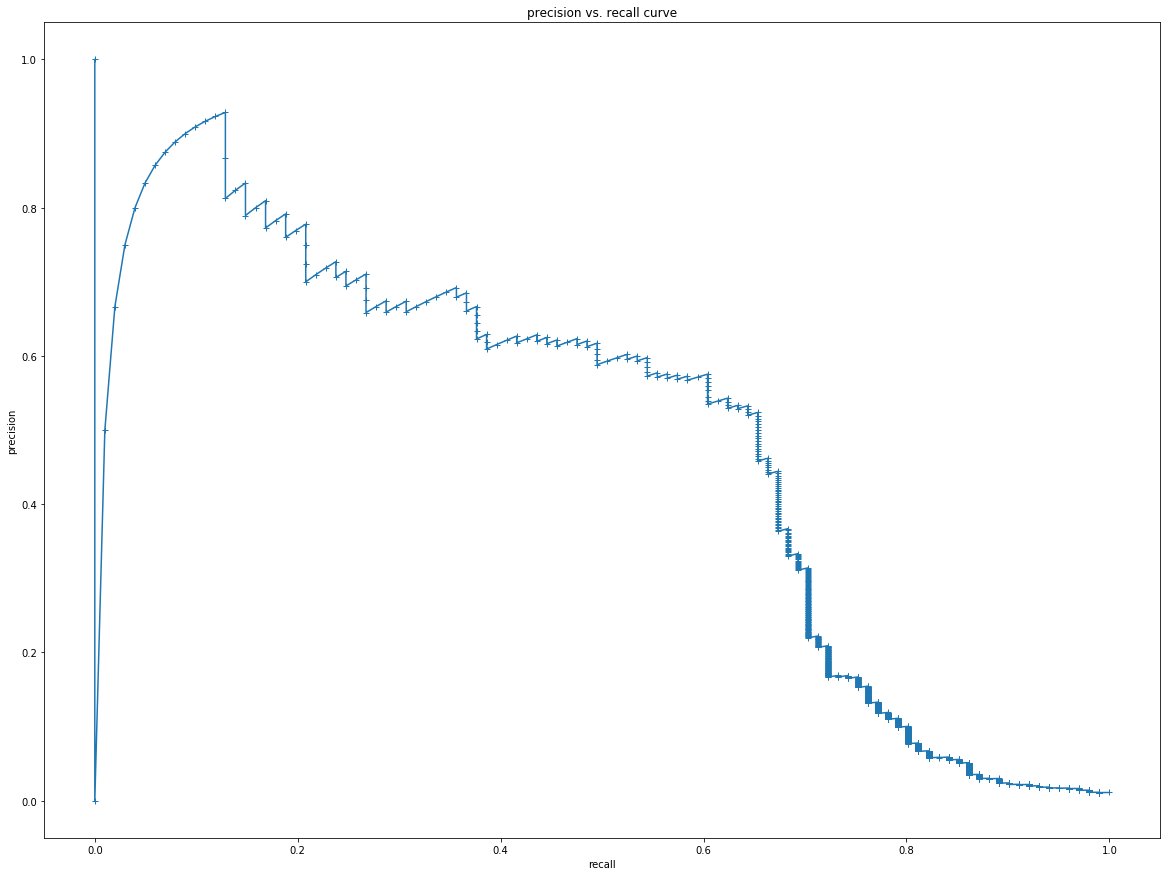

In [60]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(20,15))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()